In [157]:
import torch
import numpy as np
import torch.nn as nn
from torch.nn.functional import softplus

#DATA IMPORTING LIBRARIES
# Add the src folder to the path
import sys
sys.path.insert(0, '../src/')

from data.dataloader import MidiDataset
from data.bar_transform import BarTransform
from torch.utils.data import Dataset, DataLoader

from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader, random_split


#half of this is not yet needed but maybe it will be to visualize the latent space
import matplotlib.pyplot as plt
from IPython.display import Image, display, clear_output
import numpy as np
from sklearn.decomposition import PCA
%matplotlib nbagg
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette(sns.dark_palette("purple"))


cuda = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


NOTESPERBAR=16 #total notes in one bar

totalbars=16 #total bars as input 
NUM_PITCHES=60 # all possible notes to play


TOTAL_NOTES=NOTESPERBAR*totalbars

num_features=NUM_PITCHES #size of input feature vector

batch_size = 64 #actual batchsize

TEACHER_FORCING=True #not used but it will be needed


LOADING DATA

In [168]:
transform = BarTransform(bars=totalbars, note_count=NUM_PITCHES)#configures number of input bars

midi_dataset = MidiDataset(csv_file='./concat.csv', transform = transform) #imports dataset

midi_dataset.get_mem_usage()


random_seed = 42


test_split = .8
shuffle = True

if random_seed is not None:
    np.random.seed(random_seed)
    
    
dataset_size = len(midi_dataset)           #number of musics on dataset
test_size = int(test_split * dataset_size) #test size length
train_size = dataset_size - test_size      #train data length

train_dataset, test_dataset = random_split(midi_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, shuffle=shuffle, batch_size=batch_size, num_workers=4)#, sampler=train_sampler)
test_loader = DataLoader(test_dataset, shuffle=shuffle, batch_size=batch_size, num_workers=4)#, sampler=test_sampler)

print("Train size: {}, Test size: {}".format(train_size, test_size))


D:\Users\Ramiro\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Train size: 5212, Test size: 20847


MODEL:

In [169]:


# define size variables
input_size = NUM_PITCHES

enc_hidden_size=1024 #hidden size of encoder
conductor_hidden_size=512 #hidden size of decoder

decoders_hidden_size=512 #hidden size of decoder
decoders_initial_size=32 #decoder input size

n_layers_conductor=2 #not being used rn cuz number of layers is incorrect
n_layers_decoder=3 #not being used rn cuz number of layers is incorrect

latent_features=256 #latent space dimension

sequence_length = 16 #notes per decoder



class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_features,teacher_forcing):
        super(VariationalAutoencoder, self).__init__()
        
        
        self.teacher_forcing = teacher_forcing
        self.latent_features = latent_features
               
        #data goes into bidirectional encoder
        self.encoder = torch.nn.LSTM(
                batch_first = True,
                input_size = input_size,
                hidden_size = enc_hidden_size,
                num_layers = 1,
                bidirectional = True)
        
        #encoded data goes onto connect linear layer. inputs must be*2 because LSTM is bidirectional
        #output must be 2*latentspace because it needs to be split into miu and sigma right after.
        self.encoderOut = nn.Linear(in_features=enc_hidden_size*2, out_features=latent_features*2)
        
        #after being converted data goes through a fully connected layer
        self.linear_z = nn.Linear(in_features=latent_features, out_features=decoders_initial_size)
        
        # Define the conductor and note decoder
        self.conductor = nn.LSTM(decoders_initial_size, decoders_initial_size, num_layers=1,batch_first=True)
        self.decoder = nn.LSTM(NUM_PITCHES+decoders_initial_size, decoders_initial_size, num_layers=1,batch_first=True)
        
                # Linear note to note type (classes/pitches)
        self.linear = nn.Linear(decoders_initial_size, NUM_PITCHES)

        
    #used to initialize the hidden layer of the encoder to zero before every batch
    def init_hidden(self, batch_size):
        #must be 2 x batch x hidden_size because its a bi-directional LSTM
        init = torch.zeros(2, batch_size, enc_hidden_size, device=device)
        c0 = torch.zeros(2, batch_size, enc_hidden_size, device=device)
    
        #2 because has 2 layers
        #n_layers_conductor
        init_conductor = torch.zeros(1, batch_size, decoders_initial_size, device=device)
        c_condunctor = torch.zeros(1, batch_size, decoders_initial_size, device=device)
    
        #2 because has 2 layers
        #n_layers_decoder
        #init_decoders = torch.zeros(1, batch_size, decoders_hidden_size, device=device)
        #c_decoders= torch.zeros(1, batch_size, decoders_hidden_size, device=device)
        
        
        
        
        return init,c0,init_conductor,c_condunctor


    def forward(self, x):
        
        the_input = x
        
        outputs = {}
        
        #print("TEACHER FORCING",self.teacher_forcing)
        
        batch_size = x.size(0)
        
        #creates hidden layer values
        h0,c0,hconductor,cconductor = self.init_hidden(batch_size)
        
        #resets encoder at the beginning of every batch and gives it x
        x, hidden = self.encoder(x, ( h0,c0))
        
        #goes from 4096 to 1024
        x = self.encoderOut(x)      
        
        # Split encoder outputs into a mean and variance vector 
        mu, log_var = torch.chunk(x, 2, dim=-1)
                
        # Make sure that the log variance is positive
        log_var = softplus(log_var)
               
        # :- Reparametrisation trick
        # a sample from N(mu, sigma) is mu + sigma * epsilon
        # where epsilon ~ N(0, 1)
                
        # Don't propagate gradients through randomness
        with torch.no_grad():
            batch_size = mu.size(0)
            epsilon = torch.randn(batch_size, 1, self.latent_features)
            
            if cuda:
                epsilon = epsilon.cuda()
        
        #setting sigma
        sigma = torch.exp(log_var*2)
        
        #generate z - latent space
        z = mu + epsilon * sigma

        #decrese space
        z = self.linear_z(z)


        #make dimensions fit (NOT SURE IF THIS IS ENTIRELY CORRECT)
        #z = z.permute(1,0,2)

        #DECODER ##############
        
        conductor_hidden = (hconductor,cconductor)
        
        counter=0
        
        notes = torch.zeros(batch_size,TOTAL_NOTES,NUM_PITCHES,device=device)

        # For the first timestep the note is the embedding
        note = torch.zeros(batch_size, 1 , NUM_PITCHES,device=device)
    
        # Go through each element in the latent sequence
        for i in range(16):
            
     
            
            embedding, conductor_hidden = self.conductor(z[:,i,:].view(batch_size,1, -1), conductor_hidden)    
            
            
            
           
            if self.teacher_forcing:
                
                 # Reset the decoder state of each 16 bar sequence
                decoder_hidden = (torch.randn(1,batch_size, decoders_initial_size,device=device), torch.randn(1,batch_size, decoders_initial_size,device=device))
                

                
                embedding = embedding.expand(batch_size, NOTESPERBAR, embedding.shape[2])

                e = torch.cat([embedding,the_input[:,range(i*16,i*16+16),:]],dim=-1)
                #print(e.shape)
                notes2, decoder_hidden = self.decoder(e, decoder_hidden)
                
                
                aux = self.linear(notes2)
                    
                #print("WOWOOWOW",aux.shape)
                aux=torch.softmax(aux, dim=2);
                    
                    
                #generates 16 notes per batch at a time
                notes[:,range(i*16,i*16+16),:]=aux;
                
               
      
                
                
            else:           
                
                
                
                 # Reset the decoder state of each 16 bar sequence
                decoder_hidden = (torch.randn(1,batch_size, decoders_initial_size,device=device), torch.randn(1,batch_size, decoders_initial_size,device=device))
            
                
                for _ in range(sequence_length):
                    # Concat embedding with previous note
                    
                    #print("WHOLE INPUT SHAPE",the_input.shape)
                    #print("SHAPE OF EMBED",embedding.shape)
                    #print("SHAPE OF NOTE",note.shape)
                    
                    #print("EMBEDDI",embedding.shape)
                    #print("NOTI",note.shape)
                    
                    e = torch.cat([embedding, note], dim=-1)
                    #print("SHAPE OF E",e.shape)
                    e = e.view(batch_size, 1, -1)
                    #print("SHAPE OF E VIEW",e.shape)
                    #print("SHAPE OF HIDDEL",decoder_hidden[0].shape)
                    #print("SHAPE OF E First ELm",e.shape)

                    # Generate a single note (for each batch)
                    note, decoder_hidden = self.decoder(e, decoder_hidden)
                    
                    #print("OUTTY",note.shape)
                    
                    aux = self.linear(note)
                    
                    #print("WOWOOWOW",aux.shape)
                    aux=torch.softmax(aux, dim=2);
                    
                    
                    
                    #print("SHAPE OUTPUT",aux.shape)
                    #print("NOTES",notes.shape)
                    #print("NOTEACESS",notes[:,counter,:].shape)
                    notes[:,counter,:]=aux.squeeze();
                    
                    note=aux
                    
                    #print("SHAPE OF NOTE",note.shape)

                    counter=counter+1


        outputs["x_hat"] = notes
        outputs["z"] = z
        outputs["mu"] = mu
        outputs["log_var"] = log_var
        
        return outputs

net = VariationalAutoencoder(latent_features,TEACHER_FORCING)

# Transfer model to GPU if available
if cuda:
    net = net.cuda()

print(net)

VariationalAutoencoder(
  (encoder): LSTM(60, 1024, batch_first=True, bidirectional=True)
  (encoderOut): Linear(in_features=2048, out_features=512, bias=True)
  (linear_z): Linear(in_features=256, out_features=32, bias=True)
  (conductor): LSTM(32, 32, batch_first=True)
  (decoder): LSTM(92, 32, batch_first=True)
  (linear): Linear(in_features=32, out_features=60, bias=True)
)


Optimizer

In [170]:
#directly taken from notebook, probably some adaptation might be needed

from torch.nn.functional import binary_cross_entropy
from torch import optim



def ELBO_loss(y, t, mu, log_var):
    # Reconstruction error, log[p(x|z)]
    # Sum over features
    likelihood = -binary_cross_entropy(y, t, reduction="none")
    likelihood = likelihood.view(likelihood.size(0), -1).sum(1)

    # Regularization error: 
    # Kulback-Leibler divergence between approximate posterior, q(z|x)
    # and prior p(z) = N(z | mu, sigma*I).
    
    # In the case of the KL-divergence between diagonal covariance Gaussian and 
    # a standard Gaussian, an analytic solution exists. Using this excerts a lower
    # variance estimator of KL(q||p)
    kl = -0.5 * torch.sum(1 + log_var - mu**2 - torch.exp(log_var), dim=1)

    # Combining the two terms in the evidence lower bound objective (ELBO) 
    # mean over batch
    ELBO = torch.mean(likelihood) - torch.mean(kl)
    
    # notice minus sign as we want to maximise ELBO
    return -ELBO, kl.sum()



# define our optimizer
# The Adam optimizer works really well with VAEs.
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = ELBO_loss

Testing if forward pass works

In [171]:
from torch.autograd import Variable

#setting dummy data
#Generating dummy data
a= np.random.randint(NUM_PITCHES, size=TOTAL_NOTES)
data = np.zeros((TOTAL_NOTES, NUM_PITCHES))
data[np.arange(TOTAL_NOTES), a] = 1 #generating dummy data

a= np.random.randint(NUM_PITCHES, size=TOTAL_NOTES)
data1 = np.zeros((TOTAL_NOTES, NUM_PITCHES))
data1[np.arange(TOTAL_NOTES), a] = 1 #generating dummy data
d=np.zeros((2,TOTAL_NOTES, NUM_PITCHES))
d[0]=data
d[1]=data1

print(d.shape)

#adding 1 dimension, 1x32x4
x = d#data[np.newaxis, :, :]



#setting input ans tensor variable
x = Variable(torch.Tensor(x))

if cuda:
    x = x.cuda()
    
    

#running forward pass
outputs = net(x)


#AFTER THIS NOTHING IS DONE YET ------
x_hat = outputs["x_hat"]
mu, log_var = outputs["mu"], outputs["log_var"]
z = outputs["z"]

loss, kl = loss_function(x_hat, x, mu, log_var)



print(x.shape)
print(x_hat.shape)
print(z.shape)
print(loss)
print(kl)

(2, 256, 60)
torch.Size([2, 256, 60])
torch.Size([2, 256, 60])
torch.Size([2, 256, 32])
tensor(1343.6649, device='cuda:0', grad_fn=<NegBackward>)
tensor(20130.5762, device='cuda:0', grad_fn=<SumBackward0>)


## TRAINING

In [172]:
from torch.autograd import Variable

import os
tmp_img = "tmp_vae_out.png"

num_epochs = 100

train_loss, valid_loss = [], []
train_kl, valid_kl = [], []
#epochs loop
for epoch in range(num_epochs):
    
    
    
    batch_loss, batch_kl = [], []
    net.train()

    for i_batch, sample_batched in enumerate(train_loader):
        x = sample_batched['piano_rolls']

        x = x.type('torch.FloatTensor')
        
        if i_batch%10==0:
            print("batch:",i_batch)

        x = Variable(x)

        # This is an alternative way of putting
        # a tensor on the GPU
        x = x.to(device)

        outputs = net(x)
        x_hat = outputs['x_hat']
        mu, log_var = outputs['mu'], outputs['log_var']

        elbo, kl = loss_function(x_hat, x, mu, log_var)

        optimizer.zero_grad()
        elbo.backward()
        optimizer.step()

        batch_loss.append(elbo.item())
        batch_kl.append(kl.item())

    train_loss.append(np.mean(batch_loss))
    train_kl.append(np.mean(batch_kl))

    # Evaluate, do not propagate gradients
    with torch.no_grad():
        net.eval()

        # Just load a single batch from the test loader
        x = next(iter(test_loader))
        x = Variable(x['piano_rolls'].type('torch.FloatTensor'))

        x = x.to(device)

        outputs = net(x)
        x_hat = outputs['x_hat']
        mu, log_var = outputs['mu'], outputs['log_var']
        z = outputs["z"]

        elbo, kl = loss_function(x_hat, x, mu, log_var)

        # We save the latent variable and reconstruction for later use
        # we will need them on the CPU to plot
        x = x.to("cpu")
        x_hat = x_hat.to("cpu")
        z = z.detach().to("cpu").numpy()

        valid_loss.append(elbo.item())
        valid_kl.append(kl.item())

    if epoch == 0:
        continue
            
    # -- Plotting --
    f, axarr = plt.subplots(2, 1, figsize=(10, 10))
    
    
    # Loss
    ax = axarr[0]
    ax.set_title("ELBO")
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Error')

    ax.plot(np.arange(epoch+1), train_loss, color="black")
    ax.plot(np.arange(epoch+1), valid_loss, color="gray", linestyle="--")
    ax.legend(['Training', 'Validation'])
    
    
        # KL / reconstruction
    ax = axarr[1]
    
    ax.set_title("Kullback-Leibler Divergence")
    ax.set_xlabel('Epoch')
    ax.set_ylabel('KL divergence')


    ax.plot(np.arange(epoch+1), train_kl, color="black")
    ax.plot(np.arange(epoch+1), valid_kl, color="gray", linestyle="--")
    ax.legend(['Training', 'Validation'])
    
    
    
    plt.savefig(tmp_img)
    plt.close(f)
    display(Image(filename=tmp_img))
    clear_output(wait=True)

    os.remove(tmp_img)


batch: 0
batch: 10


KeyboardInterrupt: 

ValueError: x and y must have same first dimension, but have shapes (10,) and (9,)

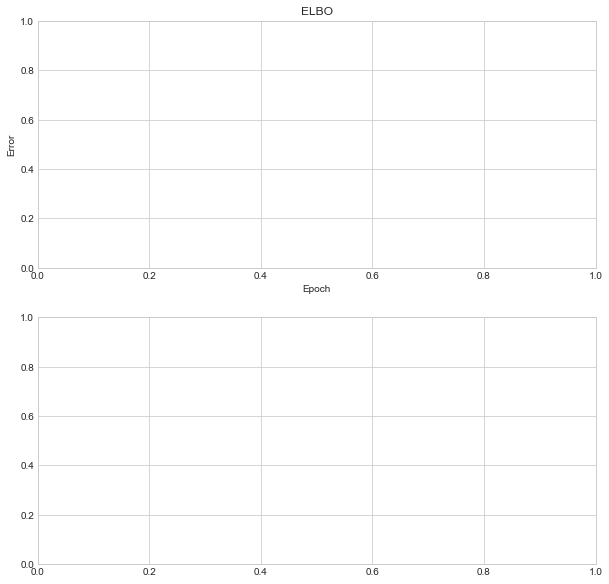

In [175]:
          
# -- Plotting --
f, axarr = plt.subplots(2, 1, figsize=(10, 10))


# Loss
ax = axarr[0]
ax.set_title("ELBO")
ax.set_xlabel('Epoch')
ax.set_ylabel('Error')

ax.plot(np.arange(epoch+1), train_loss, color="black")
ax.plot(np.arange(epoch+1), valid_loss, color="gray", linestyle="--")
ax.legend(['Training', 'Validation'])


    # KL / reconstruction
ax = axarr[1]

ax.set_title("Kullback-Leibler Divergence")
ax.set_xlabel('Epoch')
ax.set_ylabel('KL divergence')


ax.plot(np.arange(epoch+1), train_kl, color="black")
ax.plot(np.arange(epoch+1), valid_kl, color="gray", linestyle="--")
ax.legend(['Training', 'Validation'])